Experiment on using various distortion parameterization to map AI-predicted depth map to a ground truth depth map, which can be useful for 3D reconstruction tasks.

To signal overfitting, models are trained with L2 loss and evaluated with L1 loss.

Overall, classical linear least squares on orthogonal basis perform significantly better than deep learning parameterizations.

For the specific test image, I recommend "Linear least squares, embedded and fused depth and positions", with nd=3 and npos=1. The model coefficients have an analytical solution in the form of solution to a 36x36 linear system with a positive definite matrix. It is deterministic, end-to-end differentiable, outperforms all deep learning models in loss, and produces visually appealing results.

In [1]:
import cv2
import torch
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import sys, os
depth_anything_path = "/home/harry7557558/GitHub/external/Depth-Anything-V2/"
sys.path += [depth_anything_path]
current_directory = os.getcwd()
os.chdir(depth_anything_path)

from depth_anything_v2.dpt import DepthAnythingV2

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
model = model.to(device).eval()

print(model)

xFormers not available
xFormers not available


DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

Load image + Predict depth

Image size: (640, 480)


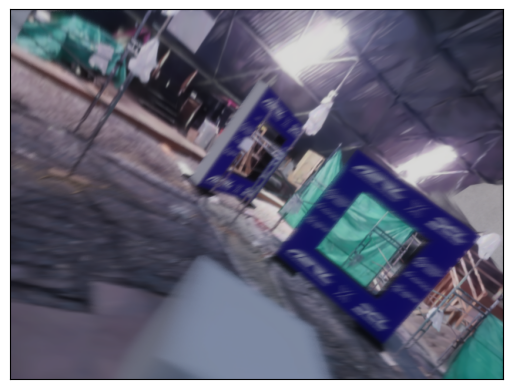

508.91984000918455 ms
(3, 480, 640) (480, 640)
0.0417574979364872 4.15289831161499
0.6203486323356628 1.0000001192092896


In [2]:
from PIL import Image

filename = "/home/harry7557558/Unity/Projects/ssplat-rt/DataExport/yolo_gates/gates_labeled_20241030/dome/00009.png"

x = Image.open(filename).convert("RGB")

print("Image size:", x.size)

import matplotlib.pyplot as plt
plt.imshow(x)
plt.xticks([])
plt.yticks([])
plt.show()

x = np.array(x)

from time import perf_counter
with torch.no_grad():
    torch.cuda.synchronize()
    time0 = perf_counter()

    pred_depth = model.infer_image(x)

    torch.cuda.synchronize()
    time1 = perf_counter()
    print(1000*(time1-time0), 'ms')

pred_depth /= np.mean(pred_depth)

x = np.transpose(x, (2, 0, 1)).astype(np.float32) / 255.0
print(x.shape, pred_depth.shape)
print(pred_depth.min().item(), pred_depth.max().item())
print(np.median(pred_depth).item(), pred_depth.mean().item())

Load GT depth

Generated using https://github.com/harry7557558/ssplat-rt-unity (currently private)

In [3]:
def load_depth_map(file_path):
    with open(file_path, 'rb') as f:
        depth_map = np.fromfile(f, dtype=np.float32)
    return depth_map.reshape(x[0].shape)

def decompose_camera(mat):
    R = mat[:3,:3].reshape((1,1,3,3))
    P = mat[3:,:3].reshape((1,1,1,3))
    T = mat[:3,3:].reshape((1,1,3,1))
    S = mat[3:,3:].reshape((1,1,1,1))
    return R, P, T, S

def project_depth(depth, shader_proj):
    h, w = depth.shape
    R, P, T, S = decompose_camera(shader_proj)
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    #u, v = np.meshgrid(u, -v)
    u, v = np.meshgrid(u, v)
    c = np.stack((u, v, depth), axis=2).reshape((h,w,3,1))
    A = R - np.matmul(c, P)
    b = c*S - T
    cam_pos = -np.linalg.solve(R, T).reshape((1,1,3))
    return cam_pos, np.linalg.solve(A, b.squeeze(-1))

raw_depth = load_depth_map(filename.replace(".png", "_depth.bin"))
# print(depth)

import json
with open(filename[:filename.rfind('/')]+"/scene_info.json") as fp:
    scene_info = json.load(fp)
scene_data = scene_info[filename[filename.rfind('/')+1:filename.rfind('.')]]
shader_proj = np.array(scene_data['shaderProjection']).reshape(4, 4)
print(shader_proj)
_, pcl = project_depth(raw_depth, shader_proj)
print(pcl.shape)
gt_depth = -pcl[..., 2]
print(gt_depth.min().item(), gt_depth.mean().item(), gt_depth.max().item())

[[ 1.28386092e+00 -7.81597000e-14 -6.25000200e-02 -7.81597000e-14]
 [-7.81597000e-14 -1.71181417e+00 -5.55555400e-02 -7.81597000e-14]
 [-7.81597000e-14 -7.81597000e-14  1.00016659e-04  1.00009991e-02]
 [-7.81597000e-14 -7.81597000e-14 -9.99999940e-01 -7.81597000e-14]]
(480, 640, 3)
1.2258084641876625 7.212716307035398 18.481649214282882


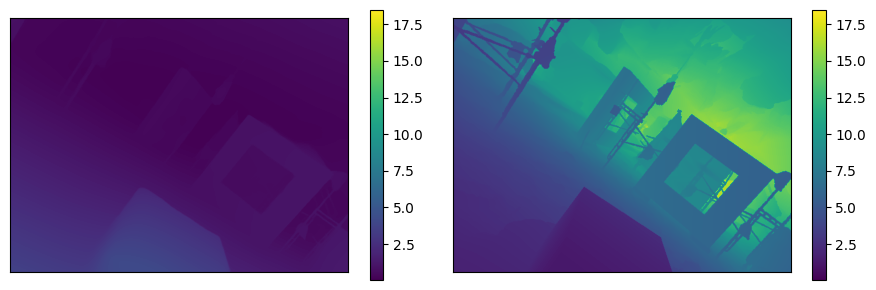

In [4]:
def plot_depths(pred, gt):
    fig = plt.figure(figsize=(9, 3))
    v0 = min(np.amin(pred), np.amin(gt))
    v1 = max(np.amax(pred), np.amax(gt))
    params = { 'vmin': v0, 'vmax': v1, 'cmap': 'viridis', 'aspect': 'equal' }
    plt.subplot(1, 2, 1)
    plt.imshow(pred, **params)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(gt, **params)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

plot_depths(pred_depth, gt_depth)


Linear regression

Without log
-3.069057133226615 10.28177437686392
L1: 0.2812151613922005


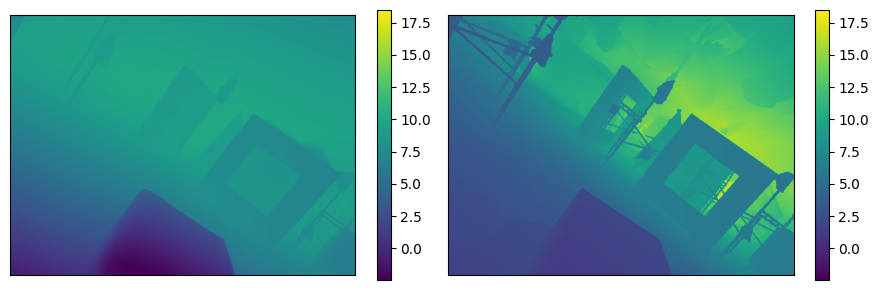

With log
-3.2182906494944996 5.777260266495651
L1: 0.2336829889444339


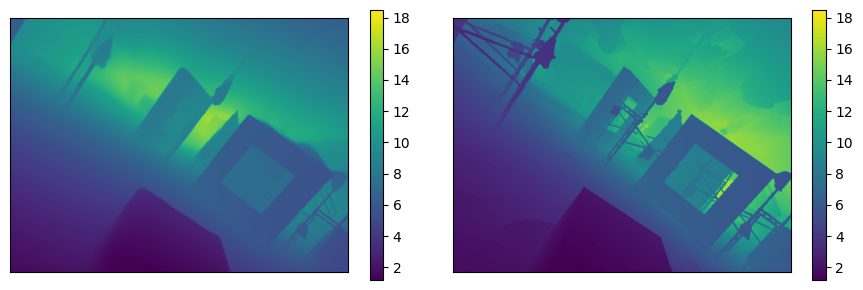

In [5]:
def linregress(x, y):
    shape = x.shape
    x, y = x.flatten(), y.flatten()
    A = np.stack((x, np.ones_like(x)))
    m, b = np.linalg.solve(A@A.T, A@y)
    print(m, b)
    return (m * x + b).reshape(shape)

print("Without log")
y1 = linregress(pred_depth, gt_depth)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("With log")
y1 = linregress(np.log(pred_depth), gt_depth)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


Linear regression with position

Without log
[ 8.9060511  -1.69333441  3.20461539 -1.77229716]
L1: 0.20120533482274694


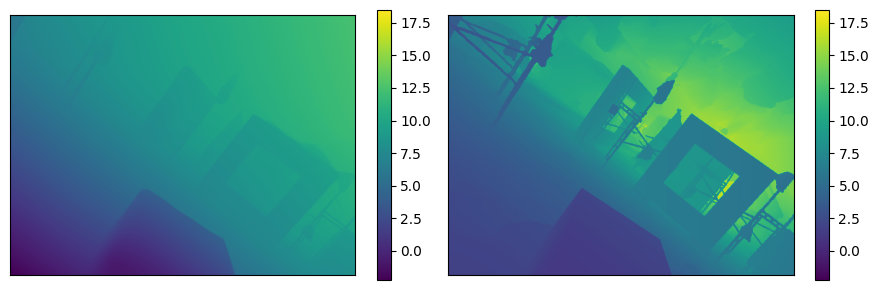

With log
[ 6.12720834 -2.43370719  3.14761958 -0.80776713]
L1: 0.15022670339897803


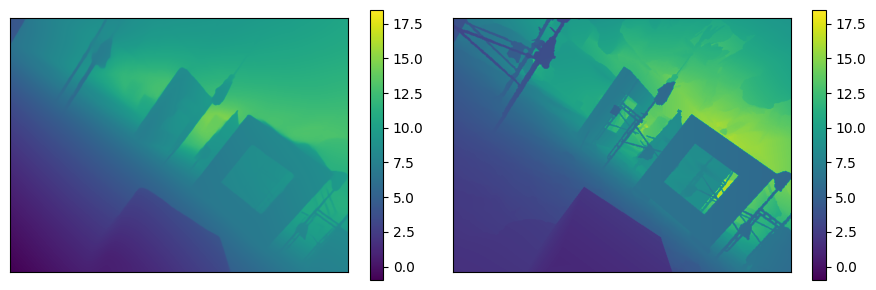

In [6]:
def linregress_with_pos(x, y):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), y.flatten()
    u, v = u.flatten(), v.flatten()
    A = np.stack((np.ones_like(x), x, u, v))
    c = np.linalg.solve(A@A.T, A@y)
    print(c)
    return (c @ A).reshape((h, w))

print("Without log")
y1 = linregress_with_pos(pred_depth, gt_depth)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("With log")
y1 = linregress_with_pos(np.log(pred_depth), gt_depth)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


Linear least squares, embedded depth

Without log, n=3
[12.32355025  6.06232907 -8.1615044   9.9079704 ]
L1: 0.2143806227361029


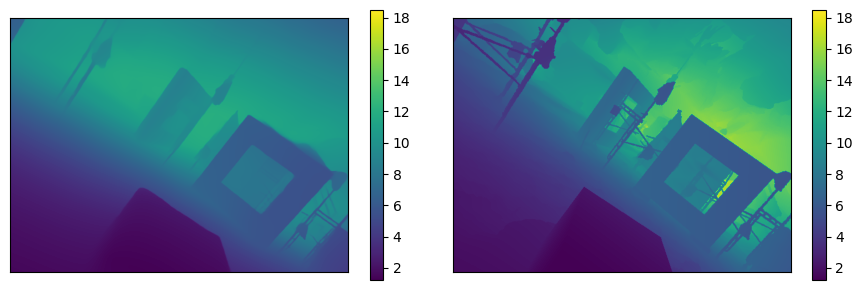

With log, n=3
[ 7.53692575 -3.73131764 -0.61910319  1.38634153]
L1: 0.21952364333721103


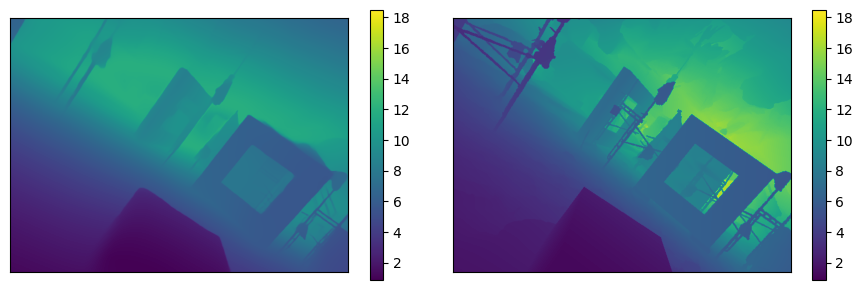

Without log, n=10
[ 1.04017895e+01  4.84554411e+01 -5.87322465e+02  5.34417770e+03
 -3.48796645e+04  1.66619175e+05 -5.85039528e+05  1.48445400e+06
 -2.59591069e+06  2.81712273e+06 -1.43730916e+06]
L1: 0.21522187722969438


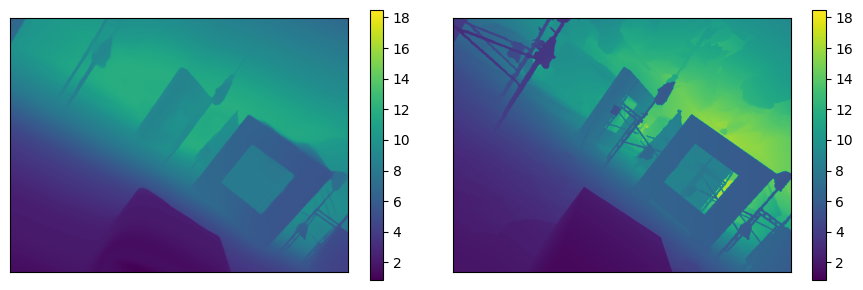

With log, n=10
[ 8.02436411e+00 -4.13435890e+00 -6.91400066e+00  8.73750753e+00
  8.70659095e+01 -1.63974973e+02 -1.18083077e+03  2.65829514e+03
  1.40035925e+04 -2.30951342e+04 -1.09111077e+05]
L1: 0.2099987783723997


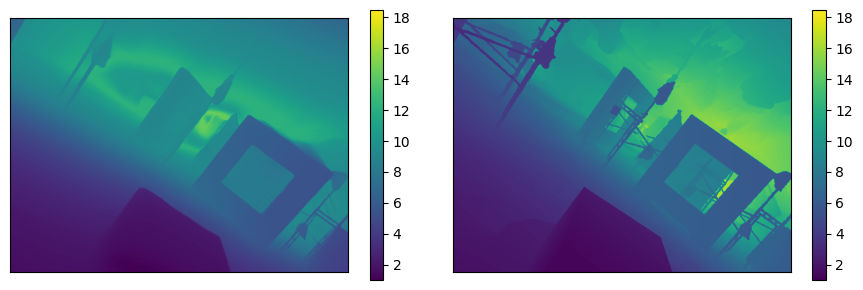

In [7]:
import math

def lsqr_ed(x, y, n, log):
    h, w = x.shape
    x, y = x.flatten(), y.flatten()
    if log:
        x = x - np.mean(x)
    x = x / np.std(x)
    A = [np.ones_like(x)]
    for i in range(1, n+1):
        A.append(x**i / math.factorial(i))
    A = np.stack(A)
    if not log:
        A *= np.exp(-x)
    c = np.linalg.solve(A@A.T, A@y)
    print(c)
    return (c @ A).reshape((h, w))

print("Without log, n=3")
y1 = lsqr_ed(pred_depth, gt_depth, 3, False)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("With log, n=3")
y1 = lsqr_ed(np.log(pred_depth), gt_depth, 3, True)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("Without log, n=10")
y1 = lsqr_ed(pred_depth, gt_depth, 10, False)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("With log, n=10")
y1 = lsqr_ed(np.log(pred_depth), gt_depth, 10, True)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


Linear least squares, embedded depth and position

nd=4, np=1
14 coefficients
L1: 0.09118656021367368


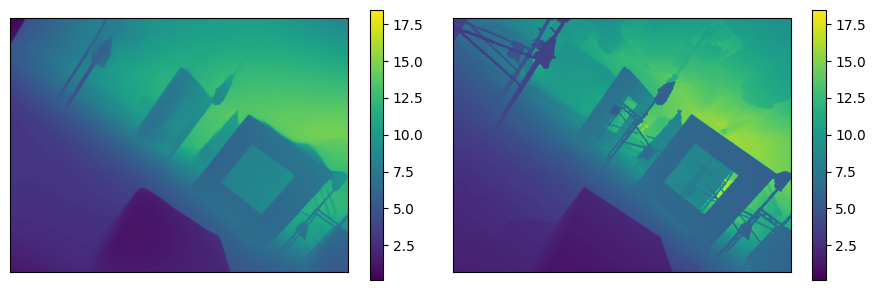

nd=4, np=2
30 coefficients
L1: 0.07272469223985234


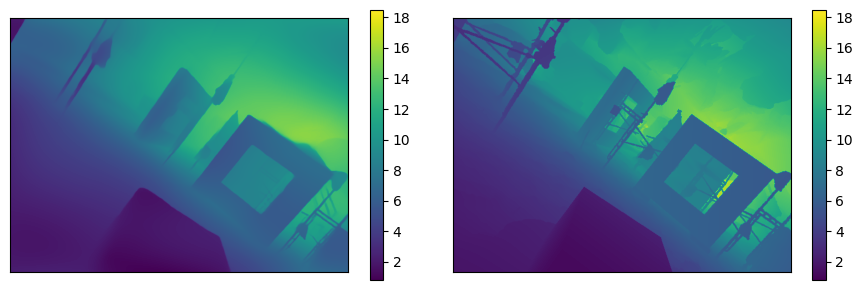

nd=4, np=3
54 coefficients
L1: 0.06774937289815443


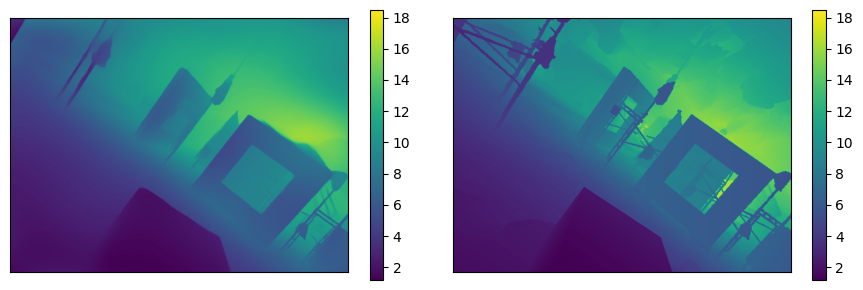

nd=4, np=4
86 coefficients
L1: 0.06830653959901357


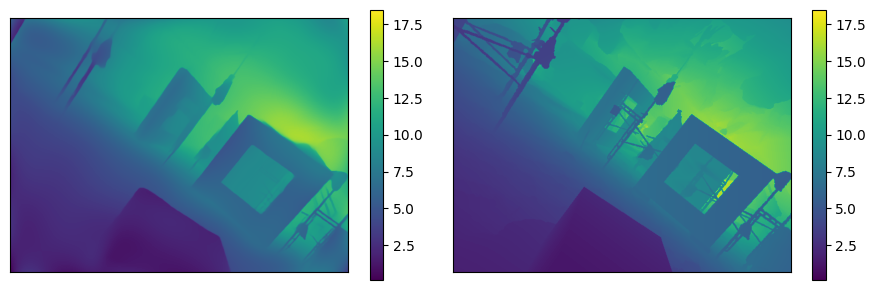

In [8]:
import math

def lsqr_edp(x, y, nd, npos):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), y.flatten()
    u, v = u.flatten(), v.flatten()
    x = x / np.std(x)
    # depth embeddings
    A = [np.exp(-x)]
    for i in range(1, nd+1):
        A.append(x**i / math.factorial(i) * np.exp(-x))
    # position embeddings
    for i in range(npos+1):
        for j in range(npos+1):
            A.append(np.cos(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
            if j != 0:
                A.append(np.cos(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
            if i != 0:
                A.append(np.sin(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
            if i != 0 and j != 0:
                A.append(np.sin(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
    A = np.stack(A)
    c = np.linalg.solve(A@A.T, A@y)
    print(len(c), 'coefficients')
    return (c @ A).reshape((h, w))

print("nd=4, np=1")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 1)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=4, np=2")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 2)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=4, np=3")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 3)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=4, np=4")
y1 = lsqr_edp(pred_depth, gt_depth, 4, 4)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


Linear least squares, embedded and fused depth and positions

nd=3, np=1
36 coefficients
L1: 0.0715041138401157


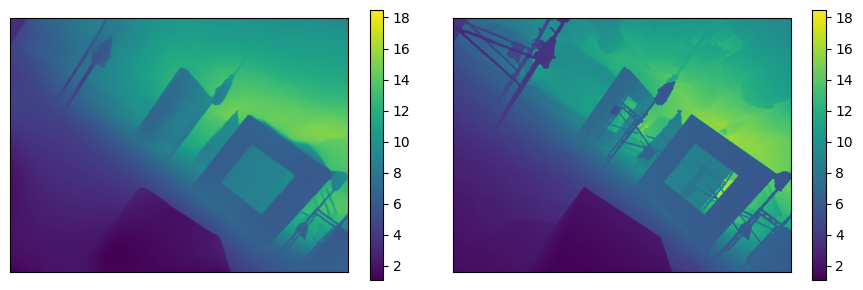

nd=1, np=2
50 coefficients
L1: 0.06396081085418132


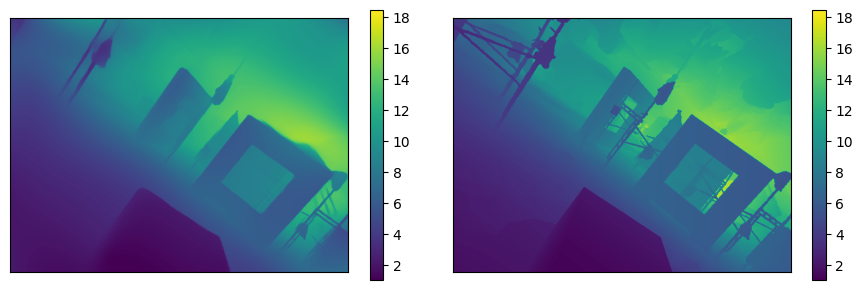

nd=2, np=2
75 coefficients
L1: 0.07331010714854623


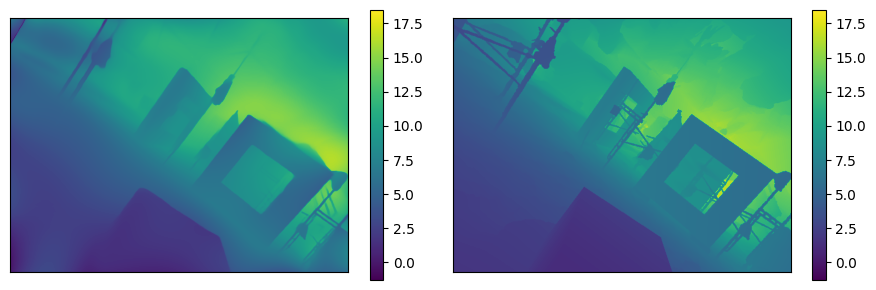

nd=3, np=2
100 coefficients
L1: 0.08156480902288941


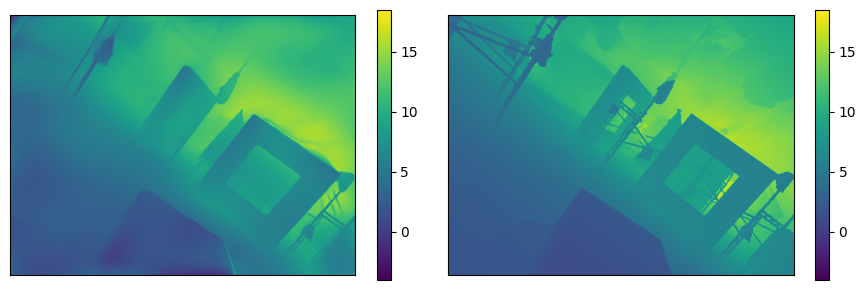

nd=4, np=2
125 coefficients
L1: 0.14498307970059918


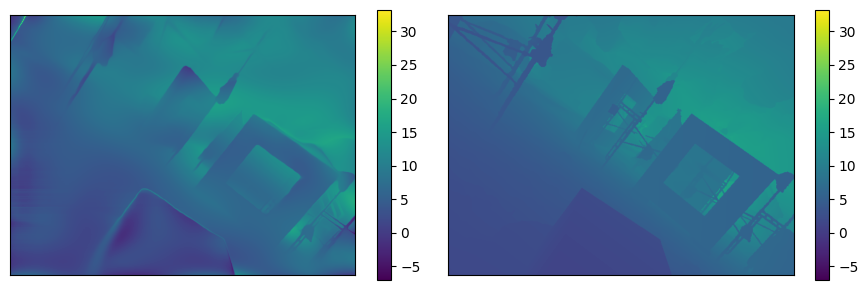

nd=2, np=3
147 coefficients
L1: 0.08118241454154874


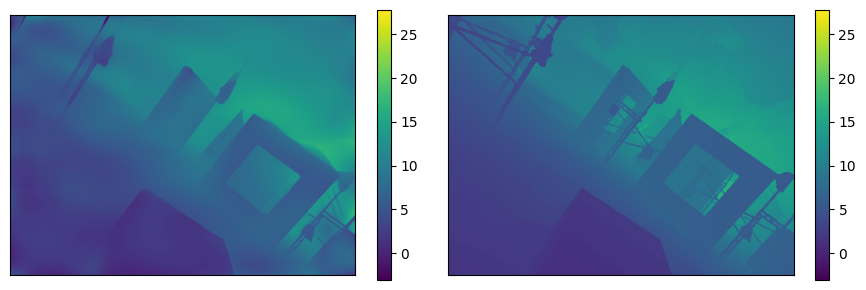

In [9]:
def lsqr_efdp(x, y, nd, npos):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), y.flatten()
    u, v = u.flatten(), v.flatten()
    x = x / np.std(x)
    A = []
    for k in range(nd+1):
        ed = x**k / math.factorial(k) * np.exp(-x)
        for i in range(npos+1):
            for j in range(npos+1):
                A.append(ed*np.cos(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
                if j != 0:
                    A.append(ed*np.cos(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
                if i != 0:
                    A.append(ed*np.sin(math.pi/2*i*u)*np.cos(math.pi/2*j*v))
                if i != 0 and j != 0:
                    A.append(ed*np.sin(math.pi/2*i*u)*np.sin(math.pi/2*j*v))
    A = np.stack(A)
    c = np.linalg.solve(A@A.T, A@y)
    print(len(c), 'coefficients')
    return (c @ A).reshape((h, w))

print("nd=3, np=1")
y1 = lsqr_efdp(pred_depth, gt_depth, 3, 1)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=1, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 1, 2)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=2, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 2, 2)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 3, 2)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=4, np=2")
y1 = lsqr_efdp(pred_depth, gt_depth, 4, 2)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=2, np=3")
y1 = lsqr_efdp(pred_depth, gt_depth, 2, 3)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


Linear least squares, individual embeddings

nd=4, np=1


9 coefficients
L1: 0.13795005900404156


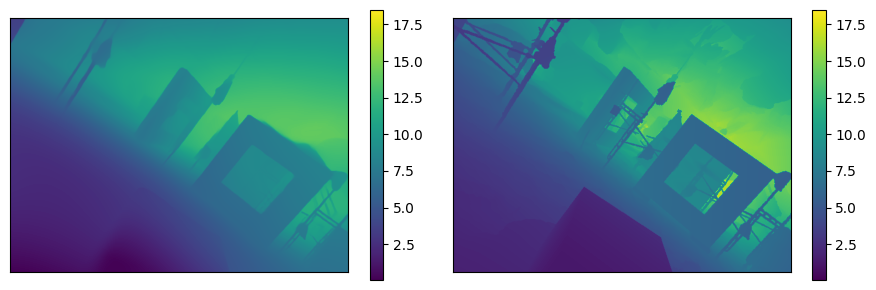

nd=4, np=2
13 coefficients
L1: 0.12891705952863197


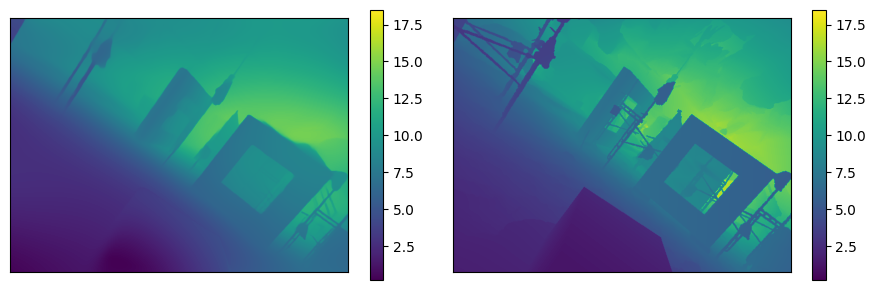

nd=4, np=12
53 coefficients
L1: 0.12692195232424894


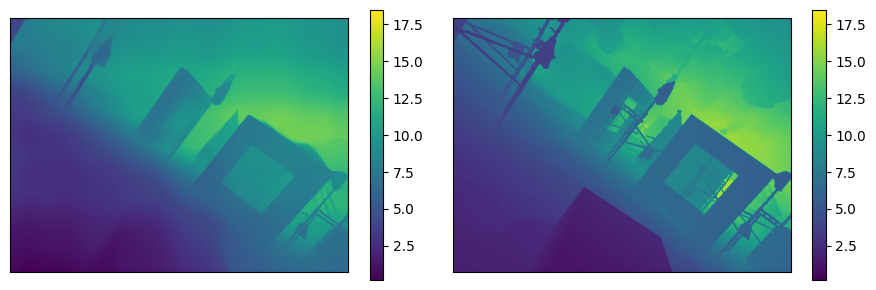

In [10]:
def lsqr_ie(x, y, nd, npos):
    h, w = x.shape
    u = (np.arange(w, dtype=np.float32)+0.5)/w * 2.0 - 1.0
    v = (np.arange(h, dtype=np.float32)+0.5)/h * 2.0 - 1.0
    u = np.repeat(u[np.newaxis, :], h, 0)
    v = np.repeat(v[:, np.newaxis], w, 1)
    x, y = x.flatten(), y.flatten()
    u, v = u.flatten(), v.flatten()
    x = x / np.std(x)
    # depth embeddings
    A = [np.exp(-x)]
    for i in range(1, nd+1):
        A.append(x**i / math.factorial(i) * np.exp(-x))
    # individual position embeddings
    for i in range(1, npos+1):
        A.append(np.cos(math.pi/2*i*u))
        A.append(np.sin(math.pi/2*i*u))
    for i in range(1, npos+1):
        A.append(np.cos(math.pi/2*i*v))
        A.append(np.sin(math.pi/2*i*v))
    A = np.stack(A)
    c = np.linalg.solve(A@A.T, A@y)
    print(len(c), 'coefficients')
    return (c @ A).reshape((h, w))

print("nd=4, np=1")
y1 = lsqr_ie(pred_depth, gt_depth, 4, 1)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=4, np=2")
y1 = lsqr_ie(pred_depth, gt_depth, 4, 2)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=4, np=12")
y1 = lsqr_ie(pred_depth, gt_depth, 4, 12)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


MLP of individual embeddings (non deterministic)

nd=3, np=0, nh=[]
5 coefficients
L1: 0.21508945806670035


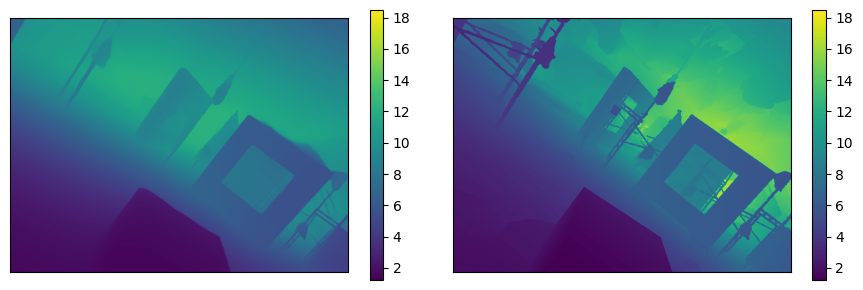

nd=3, np=0, nh=[4,4]
25 coefficients
L1: 0.21548321009913998


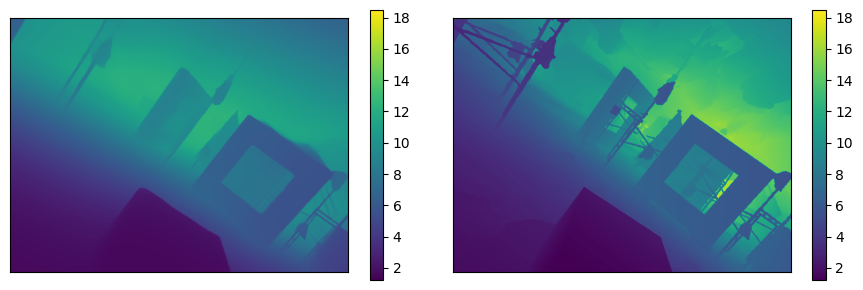

nd=3, np=1, nh=[4,4]
41 coefficients
L1: 0.12414316814066172


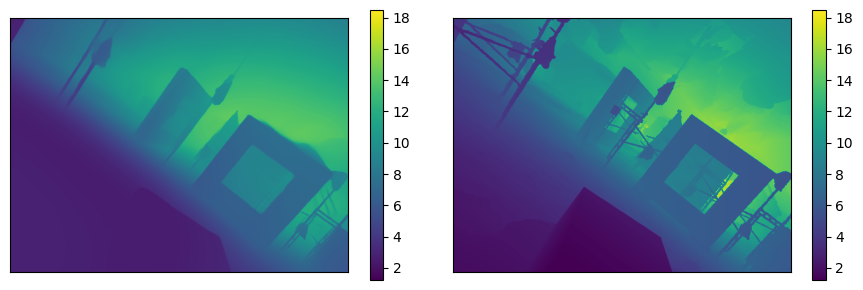

nd=3, np=1, nh=[8,4]
81 coefficients
L1: 0.11028225714796985


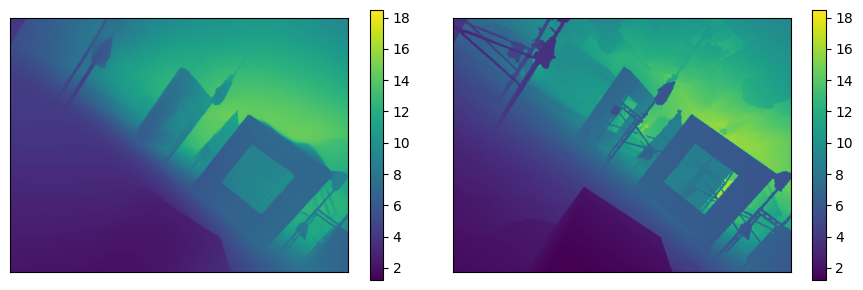

nd=3, np=2, nh=[8,4]
113 coefficients
L1: 0.08702631097579695


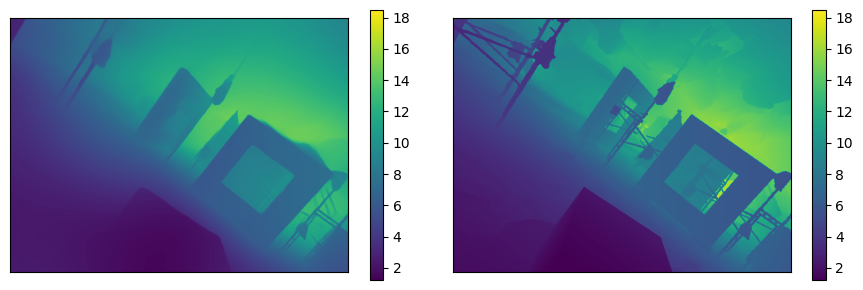

In [11]:
class MLP_IE(torch.nn.Module):
    def __init__(self, z, nd, npos, nh=[]):
        super().__init__()
        self.h, self.w = z.shape
        z = torch.from_numpy(z.flatten()).float()
        z = z / torch.std(z)
        u = (np.arange(self.w, dtype=np.float32)+0.5)/self.w * 2.0 - 1.0
        v = (np.arange(self.h, dtype=np.float32)+0.5)/self.h * 2.0 - 1.0
        u = np.repeat(u[np.newaxis, :], self.h, 0)
        v = np.repeat(v[:, np.newaxis], self.w, 1)
        u = torch.from_numpy(u.flatten()).float()
        v = torch.from_numpy(v.flatten()).float()
        # depth embeddings
        A = [torch.exp(-z)]
        for i in range(1, nd+1):
            A.append(z**i / math.factorial(i) * torch.exp(-z))
        # individual position embeddings
        for i in range(1, npos+1):
            A.append(torch.cos(math.pi/2*i*u))
            A.append(torch.sin(math.pi/2*i*u))
        for i in range(1, npos+1):
            A.append(torch.cos(math.pi/2*i*v))
            A.append(torch.sin(math.pi/2*i*v))
        self.A = torch.stack(A).T
        # model
        nh = [len(A)] + nh
        mlp = []
        for ni, no in zip(nh[:-1], nh[1:]):
            mlp.append(torch.nn.Linear(ni, no))
            mlp.append(torch.nn.GELU())
        mlp.append(torch.nn.Linear(nh[-1], 1))
        self.mlp = torch.nn.Sequential(*mlp)
    
    def forward(self):
        z = self.mlp(self.A.unsqueeze(0)).squeeze(0)
        # z = torch.exp(z)  # ensure positive
        return z.reshape((self.h, self.w))


def mlp_ie(x, y, nd, npos, nh):
    model = MLP_IE(x, nd, npos, nh)
    y = torch.from_numpy(y).float()

    nparam = 0
    for param in model.parameters():
        nparam += param.numel()
    print(nparam, "coefficients")

    optimizer = torch.optim.LBFGS(
        model.parameters(),
        line_search_fn="strong_wolfe",
        history_size=40
    )

    def grad_loss(im1, im2):
        gy1 = im1[1:,:]-im1[:-1,:]
        gy2 = im2[1:,:]-im2[:-1,:]
        gx1 = im1[:,1:]-im1[:,:-1]
        gx2 = im2[:,1:]-im2[:,:-1]
        # dy = torch.abs(gy2-gy1)
        # dx = torch.abs(gx2-gx1)
        dy = (gy2-gy1)**2
        dx = (gx2-gx1)**2
        return torch.mean(dx) + torch.mean(dy)

    loss = 0.0
    nfev = 0
    z = None
    def closure():
        nonlocal nfev, loss, z
        optimizer.zero_grad()
        z = model()
        # loss_p = torch.mean(torch.abs(z-y))
        loss_p = torch.mean((z-y)**2)
        loss_g = 10.0 * grad_loss(z, y)
        loss = loss_p + loss_g
        loss.backward()
        nfev += 1
        # print(nfev, loss.item())
        return loss

    optimizer.step(closure)

    return z.detach().cpu().numpy()


print("nd=3, np=0, nh=[]")
y1 = mlp_ie(pred_depth, gt_depth, 3, 0, [])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=0, nh=[4,4]")
y1 = mlp_ie(pred_depth, gt_depth, 3, 0, [4])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=1, nh=[4,4]")
y1 = mlp_ie(pred_depth, gt_depth, 3, 1, [4])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=1, nh=[8,4]")
y1 = mlp_ie(pred_depth, gt_depth, 3, 1, [8])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=2, nh=[8,4]")
y1 = mlp_ie(pred_depth, gt_depth, 3, 2, [8])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


SIREN of inputs (non deterministic)

nh=[]
4 coefficients
L1: 0.2027812964981156


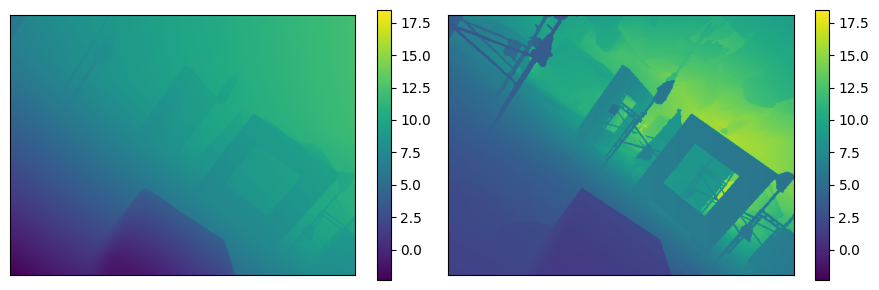

nh=[4]
21 coefficients
L1: 0.0986467087814723


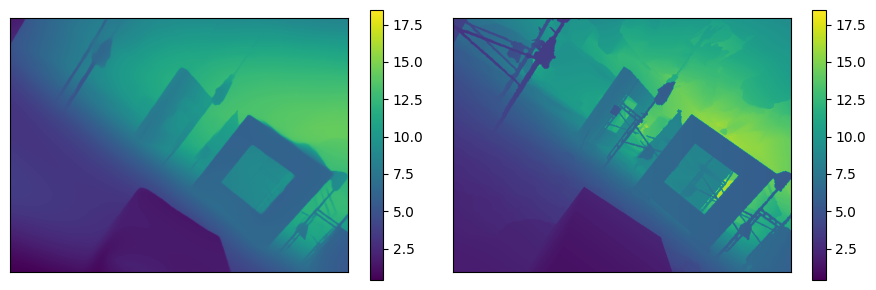

nh=[8]
41 coefficients
L1: 0.09139713819779287


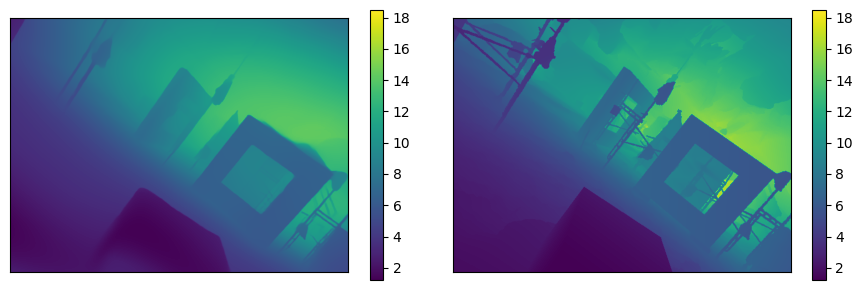

nh=[4, 4]
41 coefficients
L1: 0.09759780918985113


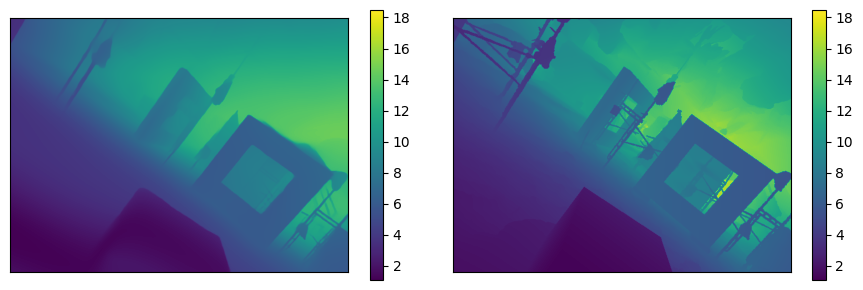

nh=[8, 4, 4]
93 coefficients
L1: 0.10186081924434043


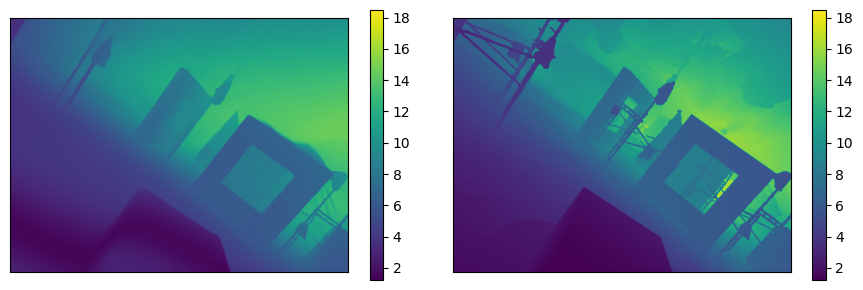

In [12]:
class SIREN_I_Activate(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

class SIREN_I(torch.nn.Module):
    def __init__(self, z, nh=[]):
        super().__init__()
        self.h, self.w = z.shape
        z = torch.from_numpy(z.flatten()).float()
        z = z / torch.std(z)
        u = (np.arange(self.w, dtype=np.float32)+0.5)/self.w * 2.0 - 1.0
        v = (np.arange(self.h, dtype=np.float32)+0.5)/self.h * 2.0 - 1.0
        u = np.repeat(u[np.newaxis, :], self.h, 0)
        v = np.repeat(v[:, np.newaxis], self.w, 1)
        u = torch.from_numpy(u.flatten()).float()
        v = torch.from_numpy(v.flatten()).float()
        self.A = torch.stack([z, u, v]).T
        # model
        nh = [self.A.shape[1]] + nh
        mlp = []
        for ni, no in zip(nh[:-1], nh[1:]):
            mlp.append(torch.nn.Linear(ni, no))
            mlp.append(SIREN_I_Activate())
        mlp.append(torch.nn.Linear(nh[-1], 1))
        self.mlp = torch.nn.Sequential(*mlp)
    
    def forward(self):
        z = self.mlp(self.A.unsqueeze(0)).squeeze(0)
        # z = torch.exp(z)  # ensure positive
        return z.reshape((self.h, self.w))


def siren_i(x, y, nh):
    model = SIREN_I(x, nh)
    y = torch.from_numpy(y).float()

    nparam = 0
    for param in model.parameters():
        nparam += param.numel()
    print(nparam, "coefficients")

    optimizer = torch.optim.LBFGS(
        model.parameters(),
        line_search_fn="strong_wolfe",
        history_size=40
    )

    def grad_loss(im1, im2):
        gy1 = im1[1:,:]-im1[:-1,:]
        gy2 = im2[1:,:]-im2[:-1,:]
        gx1 = im1[:,1:]-im1[:,:-1]
        gx2 = im2[:,1:]-im2[:,:-1]
        # dy = torch.abs(gy2-gy1)
        # dx = torch.abs(gx2-gx1)
        dy = (gy2-gy1)**2
        dx = (gx2-gx1)**2
        return torch.mean(dx) + torch.mean(dy)

    loss = 0.0
    nfev = 0
    z = None
    def closure():
        nonlocal nfev, loss, z
        optimizer.zero_grad()
        z = model()
        # loss_p = torch.mean(torch.abs(z-y))
        loss_p = torch.mean((z-y)**2)
        loss_g = 10.0 * grad_loss(z, y)
        loss = loss_p + loss_g
        loss.backward()
        nfev += 1
        # print(nfev, loss.item())
        return loss

    optimizer.step(closure)

    return z.detach().cpu().numpy()


print("nh=[]")
y1 = siren_i(pred_depth, gt_depth, [])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nh=[4]")
y1 = siren_i(pred_depth, gt_depth, [4])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nh=[8]")
y1 = siren_i(pred_depth, gt_depth, [8])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nh=[4, 4]")
y1 = siren_i(pred_depth, gt_depth, [4, 4])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nh=[8, 4, 4]")
y1 = siren_i(pred_depth, gt_depth, [8, 4, 4])
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)


Transformer of individual embeddings (non deterministic)

nd=3, np=0, nh=3, nh2=4
110 coefficients
L1: 0.21598668255244438


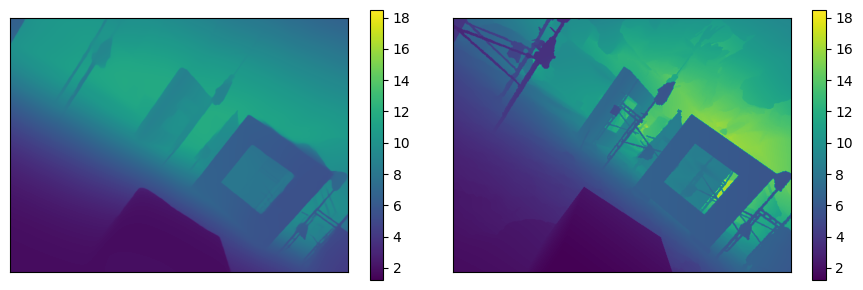

nd=3, np=1, nh=4, nh2=4
177 coefficients
L1: 0.13711773249007603


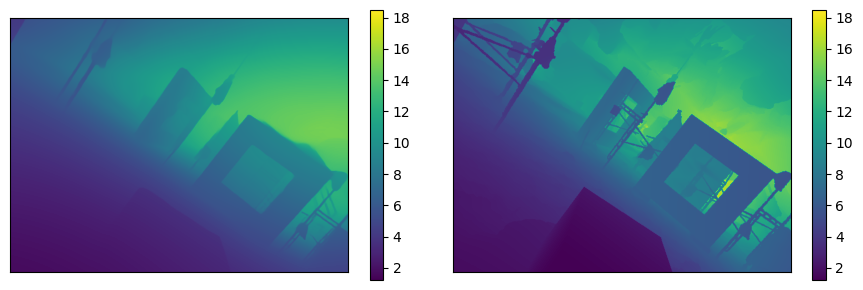

nd=3, np=1, nh=6, nh2=6
337 coefficients
L1: 0.161923965917969


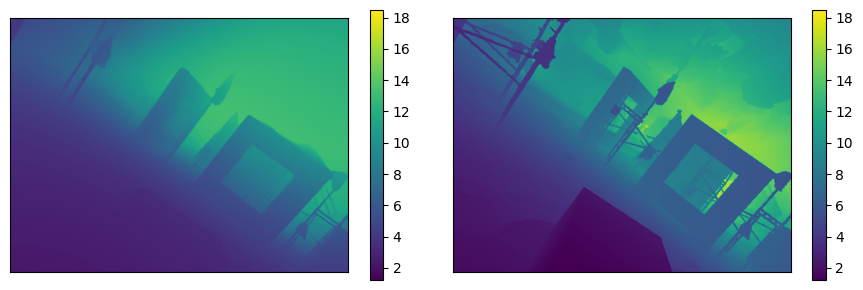

nd=3, np=2, nh=6, nh2=6
361 coefficients
L1: 0.12794407698873717


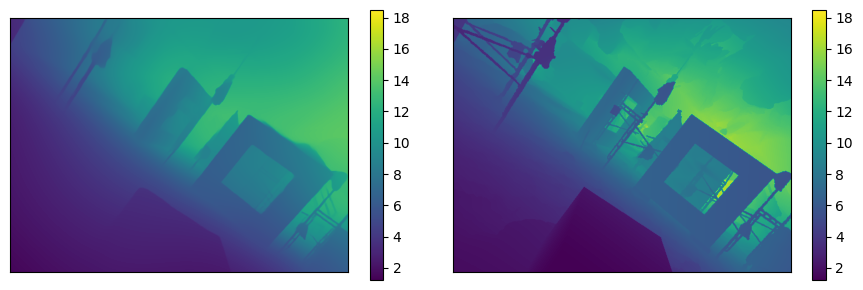

In [13]:
class TransformerAttentionModule(torch.nn.Module):
    def __init__(self, nh, nh2, nhead):
        super().__init__()
        self.self_attn = torch.nn.MultiheadAttention(nh, nhead, dropout=0.0)
        self.linear1 = torch.nn.Linear(nh, nh2)
        self.linear2 = torch.nn.Linear(nh2, nh)
        self.norm1 = torch.nn.LayerNorm(nh)
        self.norm2 = torch.nn.LayerNorm(nh)
        self.activation = torch.nn.GELU()

    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = src + src2
        src = self.norm1(src)
        src2 = self.linear2(self.activation(self.linear1(src)))
        src = src + src2
        src = self.norm2(src)
        return src

class Transformer_IE(torch.nn.Module):
    def __init__(self, z, nd, npos, nh, nh2, nhead=1, nlayer=1):
        super().__init__()
        self.h, self.w = z.shape
        z = torch.from_numpy(z.flatten()).float()
        z = z / torch.std(z)
        u = (np.arange(self.w, dtype=np.float32)+0.5)/self.w * 2.0 - 1.0
        v = (np.arange(self.h, dtype=np.float32)+0.5)/self.h * 2.0 - 1.0
        u = np.repeat(u[np.newaxis, :], self.h, 0)
        v = np.repeat(v[:, np.newaxis], self.w, 1)
        u = torch.from_numpy(u.flatten()).float()
        v = torch.from_numpy(v.flatten()).float()
        # depth embeddings
        A = [torch.exp(-z)]
        for i in range(1, nd+1):
            A.append(z**i / math.factorial(i) * torch.exp(-z))
        # individual position embeddings
        for i in range(1, npos+1):
            A.append(torch.cos(math.pi/2*i*u))
            A.append(torch.sin(math.pi/2*i*u))
        for i in range(1, npos+1):
            A.append(torch.cos(math.pi/2*i*v))
            A.append(torch.sin(math.pi/2*i*v))
        self.A = torch.stack(A).T
        # model
        self.input_proj = torch.nn.Linear(len(A), nh)
        self.layers = torch.nn.ModuleList([
            TransformerAttentionModule(nh, nh2, nhead) for _ in range(nlayer)
        ])
        self.output_proj = torch.nn.Linear(nh, 1)

    def forward(self):
        x = self.input_proj(self.A.unsqueeze(0))
        for layer in self.layers:
            x = layer(x)
        z = self.output_proj(x).squeeze(0).squeeze(-1)
        return z.reshape((self.h, self.w))

def transformer_ie(x, y, nd, npos, nh, nh2):
    model = Transformer_IE(x, nd, npos, nh, nh2)
    y = torch.from_numpy(y).float()

    nparam = 0
    for param in model.parameters():
        nparam += param.numel()
    print(nparam, "coefficients")

    optimizer = torch.optim.LBFGS(
        model.parameters(),
        line_search_fn="strong_wolfe",
        history_size=40
    )

    def grad_loss(im1, im2):
        gy1 = im1[1:,:]-im1[:-1,:]
        gy2 = im2[1:,:]-im2[:-1,:]
        gx1 = im1[:,1:]-im1[:,:-1]
        gx2 = im2[:,1:]-im2[:,:-1]
        # dy = torch.abs(gy2-gy1)
        # dx = torch.abs(gx2-gx1)
        dy = (gy2-gy1)**2
        dx = (gx2-gx1)**2
        return torch.mean(dx) + torch.mean(dy)

    loss = 0.0
    nfev = 0
    z = None
    def closure():
        nonlocal nfev, loss, z
        optimizer.zero_grad()
        z = model()
        # loss_p = torch.mean(torch.abs(z-y))
        loss_p = torch.mean((z-y)**2)
        loss_g = 10.0 * grad_loss(z, y)
        loss = loss_p + loss_g
        loss.backward()
        nfev += 1
        # print(nfev, loss.item())
        return loss

    optimizer.step(closure)

    return z.detach().cpu().numpy()


print("nd=3, np=0, nh=3, nh2=4")
y1 = transformer_ie(pred_depth, gt_depth, 3, 0, 3, 4)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=1, nh=4, nh2=4")
y1 = transformer_ie(pred_depth, gt_depth, 3, 1, 4, 4)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=1, nh=6, nh2=6")
y1 = transformer_ie(pred_depth, gt_depth, 3, 1, 6, 6)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)

print("nd=3, np=2, nh=6, nh2=6")
y1 = transformer_ie(pred_depth, gt_depth, 3, 2, 6, 6)
print('L1:', np.mean(np.abs(y1-gt_depth))/np.mean(gt_depth))
plot_depths(y1, gt_depth)
